In [2]:
import numpy as np
import random

n = 20


pg = [chr(65 + i) for i in range(n)] 

p_score = {p: np.random.randint(40, 100, size=6) for p in pg}
p_salary = {p: np.random.randint(5, 10) for p in pg}
p_vers = {p: np.random.randint(5, 10) for p in pg}
p_elig = {p: np.random.randint(50, 90) for p in pg}


u_score = np.random.randint(50, 100, size=6)
u_elig = np.random.randint(50, 90)

# User preferences (weights)
w_salary = 0.6
w_vers = 0.3
w_elig = 0.1  

q_dict = {program: 0 for program in pg}


lr = 0.1
gamma = 0.9
w_feed = 0.5 


episodes = 5000


for episode in range(episodes):
    
    p = random.choice(pg)
    
    similarity = np.dot(u_score, p_score[p]) / (np.linalg.norm(u_score) * np.linalg.norm(p_score[p]))

    elig_score = u_elig / p_elig[p]

    r_salary = p_salary[p] * similarity
    r_vers = p_vers[p] * similarity
    r_elig = elig_score * 10 


    reward = (w_salary * r_salary + 
              w_vers * r_vers + 
              w_elig * r_elig)


    max_q = max(q_dict.values())
    curr_q = q_dict[p]
    new_q = (1 - lr) * curr_q + lr * (reward + gamma * max_q)
    q_dict[p] = new_q

top_n = 5 
rec_p = sorted(q_dict, key=q_dict.get, reverse=True)[:top_n]

print("Top recommended programs")
for i, p in enumerate(rec_p, 1):
    print(f"{i}. Program {p}")




Top recommended programs
1. Program J
2. Program N
3. Program C
4. Program Q
5. Program B


In [4]:
u_feed = {}
for p in rec_p:
    while True:
        try:
            score = int(input(f"Rate Program {p} (0-5): "))
            if 0 <= score <= 5:
                u_feed[p] = score
                break
            else:
                print("Please enter a valid score between 0 and 5.")
        except ValueError:
            print("Please enter a valid integer.")


In [5]:
# Adjust Q-values based on user feedback
for p, score in u_feed.items():
    if score == 0:
        # Strong disagreement: Heavily penalize the Q-value
        q_dict[p] -= w_feed * 10
    else:
        # Adjust Q-value based on the user's score (higher score = higher preference)
        q_dict[p] += w_feed * score

# Recommend the top N programs again after incorporating user feedback
revised = sorted(q_dict, key=q_dict.get, reverse=True)[:top_n]

print("\nTop recommended programs after incorporating user feedback:")
for i, p in enumerate(revised, 1):
    print(f"{i}. Program {p}")


Top recommended programs after incorporating user feedback:
1. Program Q
2. Program C
3. Program N
4. Program B
5. Program I


In [20]:
import numpy as np
import random

# Initialize program details
n_p = 20
progs = [chr(65 + i) for i in range(n_p)]
p_s = {p: np.random.randint(40, 100, size=6) for p in progs}
p_sal = {p: np.random.randint(5, 10) for p in progs}
p_vers = {p: np.random.randint(5, 10) for p in progs}
p_elg = {p: np.random.randint(50, 90) for p in progs}


u_s = np.random.randint(50, 100, size=6).astype(float)
u_elg = float(np.random.randint(50, 90))  
w_sal = 0.6
w_vers = 0.3
w_elg = 0.1

q_vals = {p: 0.0 for p in progs}
lr = 0.1
gamma = 0.9
f_adj = 0.5
epsilon_threshold = 0.01
top_n = 5


questions_pool = np.random.rand(1000)
asked_questions = []

def ask_qs():
    global asked_questions, u_s
    selected_questions = random.sample(list(questions_pool), 6)
    for weight in selected_questions:
        answer = int(input(f"Answer question (0-5): "))
        answer = max(0, min(answer, 5)) 
        u_s += answer * weight  
    asked_questions.extend(selected_questions)
    return u_s

def update_q_vals():
    epsilon = 0
    for p in progs:
        sim = np.dot(u_s, p_s[p]) / (np.linalg.norm(u_s) * np.linalg.norm(p_s[p]))
        elg_impact = u_elg / p_elg[p]
        r_sal = p_sal[p] * sim
        r_vers = p_vers[p] * sim
        r_elg = elg_impact * 10
        reward = w_sal * r_sal + w_vers * r_vers + w_elg * r_elg
        max_q = max(q_vals.values())
        old_q = q_vals[p]
        q_vals[p] = (1 - lr) * q_vals[p] + lr * (reward + gamma * max_q)
        
    return q_vals, old_q

def get_feedback(rec):
    global progs
    fb = {p: int(input(f"Rate {p} (0-5): ")) for p in rec}
    for p, score in fb.items():
        if score == 0:
            progs.remove(p)
            del q_vals[p]
        else:
            q_vals[p] += f_adj * (score - 2) * 5

max_ep = 10
for ep in range(max_ep):
    u_s = ask_qs()
    q_vals, old_q = update_q_vals()
    epsilon=abs(q_vals-old_q)
    print(q_vals, old_q)
    if len(progs) < top_n:
        break
    
    if epsilon < epsilon_threshold:
        rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
        get_feedback(rec)
        satisfied = input("Satisfied? (yes/no): ").strip().lower()

        if satisfied == 'yes':
            break

if len(progs) >= top_n:
    print("\nFinal Recommendations:")
    rec = sorted(q_vals, key=q_vals.get, reverse=True)[:top_n]
    for i, p in enumerate(rec, 1):
        print(f"{i}. {p}")
else:
    print("\nNot enough programs left to recommend. Test ends.")


15.28278415994642
15.331801220213883
15.338610623172695
15.323369475523583
15.31427076294464


ValueError: invalid literal for int() with base 10: ''

In [26]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize
import matplotlib.pyplot as plt

np.random.seed(42)

# 1. Define parameters
n_items = 1000  # Total number of items
n_traits = 6    # Number of latent traits
n_adaptive = 30  # Number of adaptive steps

# Distribution of item types: 40% Likert, 20% Binary, 20% Value, 10% Single MC, 10% Multiple MC
n_likert = int(0.3 * n_items)
n_binary = int(0.2 * n_items)
n_value = int(0.2 * n_items)
n_mc_single = int(0.15 * n_items)
n_mc_multi = int(0.15 * n_items)

# Assign item types
item_types = (['likert'] * n_likert + ['binary'] * n_binary + ['value'] * n_value +
              ['mc_single'] * n_mc_single + ['mc_multi'] * n_mc_multi)
np.random.shuffle(item_types)

# 2. Simulate latent traits for a respondent, bounded in [-3, 3]
true_th = np.random.uniform(-3, 3, size=n_traits)

# 3. Randomly initialize item parameters
a_params = np.random.randn(n_items, n_traits)  # Discrimination parameters for all items
thresholds = [np.sort(np.random.uniform(-2, 2, size=4)) for _ in range(n_items)]  # Thresholds for ordinal items
binary_b = np.random.randn(n_items)  # Difficulty parameters for binary items
value_thresh = np.sort(np.random.uniform(-2, 2, size=5))  # Thresholds for value items (0-5)
mc_params = np.random.randn(n_items, n_traits, 4)  # Discrimination params for multiple-choice

# 4. Define probability functions for GPCM

def gpcm_prob(a, th, thresholds):
    diff = np.dot(a, th)
    category_probs = []
    for k in range(len(thresholds) + 1):
        if k == 0:
            category_probs.append(1)
        else:
            category_probs.append(np.exp(np.sum(diff - thresholds[:k])))
    denom = np.sum(category_probs)
    return np.array(category_probs) / denom

# Binary Logistic Model
def bin_prob(a, b, th):
    prob = expit(np.dot(a, th) - b)
    return prob

# Nominal Response Model for single multiple-choice
def mc_single_prob(a, th):
    exponent = np.dot(a.T, th)
    numerator = np.exp(exponent)
    return numerator / np.sum(numerator)

# Nominal Response Model for multiple multiple-choice
def mc_multi_prob(a, th):
    probs = expit(np.dot(a.T, th))
    return np.clip(probs, 0, 1)

# 5. Simulate responses for different item types
def sim_response(item_type, q):
    if item_type == "binary":
        prob = bin_prob(a_params[q], binary_b[q], true_th)
        return np.random.binomial(1, prob)
    elif item_type == "likert":
        probs = gpcm_prob(a_params[q], true_th, thresholds[q])
        return np.argmax(np.random.multinomial(1, probs)) + 1
    elif item_type == "value":
        probs = gpcm_prob(a_params[q], true_th, value_thresh)
        return np.argmax(np.random.multinomial(1, probs))
    elif item_type == "mc_single":
        probs = mc_single_prob(mc_params[q], true_th)
        return np.argmax(np.random.multinomial(1, probs))
    elif item_type == "mc_multi":
        probs = mc_multi_prob(mc_params[q], true_th)
        return np.random.binomial(1, probs)

# 6. Define log-likelihood function
def log_likelihood(params, responses, selected_items):
    th = params[:n_traits]
    ll = 0
    for i, q in enumerate(selected_items):
        item_type = item_types[q]
        if item_type == "binary":
            prob = bin_prob(a_params[q], binary_b[q], th)
            prob = np.clip(prob, 1e-8, 1 - 1e-8)
            ll += responses[i] * np.log(prob) + (1 - responses[i]) * np.log(1 - prob)
        elif item_type == "likert":
            probs = gpcm_prob(a_params[q], th, thresholds[q])
            selected_category = responses[i] - 1
            ll += np.log(probs[selected_category])
        elif item_type == "value":
            probs = gpcm_prob(a_params[q], th, value_thresh)
            ll += np.log(probs[responses[i]])
        elif item_type == "mc_single":
            probs = mc_single_prob(mc_params[q], th)
            ll += np.log(probs[responses[i]])
        elif item_type == "mc_multi":
            probs = mc_multi_prob(mc_params[q], th)
            for j in range(len(responses[i])):
                ll += responses[i][j] * np.log(probs[j]) + (1 - responses[i][j]) * np.log(1 - probs[j])
    return -ll

# 7. Define adaptive testing function
def adaptive_test(n_adaptive_steps=5, noise_factor=0.1):
    est_theta = np.zeros(n_traits)
    selected_items = []
    responses = []
    information_gain = []
    
    bounds = [(-3, 3)] * n_traits  # Bound for latent traits
    
    for step in range(n_adaptive_steps):
        infos = []
        for i in range(n_items):
            if i in selected_items:
                infos.append(-np.inf)
                continue
            item_type = item_types[i]
            if item_type == "binary":
                prob = bin_prob(a_params[i], binary_b[i], est_theta)
                info = prob * (1 - prob)
            elif item_type == "likert":
                probs = gpcm_prob(a_params[i], est_theta, thresholds[i])
                info = np.sum(probs * (1 - probs))
            elif item_type == "value":
                probs = gpcm_prob(a_params[i], est_theta, value_thresh)
                info = np.sum(probs * (1 - probs))
            elif item_type == "mc_single":
                probs = mc_single_prob(mc_params[i], est_theta)
                info = np.sum(probs * (1 - probs))
            elif item_type == "mc_multi":
                probs = mc_multi_prob(mc_params[i], est_theta)
                info = np.sum(probs * (1 - probs))
            infos.append(info)
        
        # Add noise to the information gain
        infos = np.array(infos) + np.random.randn(len(infos)) * noise_factor
        
        # Select the item with the highest information
        next_item = np.argmax(infos)
        selected_items.append(next_item)
        
        # Simulate the response
        resp = sim_response(item_types[next_item], next_item)
        responses.append(resp)
        
        # Collect information gain
        information_gain.append(infos[next_item])
        
        # Update latent traits using MLE
        res = minimize(log_likelihood, est_theta, args=(responses, selected_items),
                      method='L-BFGS-B', bounds=bounds)
        est_theta = res.x[:n_traits]
        
        print(f"Step {step+1}: Selected Item {next_item+1}, Response: {resp}, Estimated Theta: {est_theta}")
    
    return est_theta, information_gain, selected_items

# 8. Run the adaptive test
final_theta, information_gain, selected_items = adaptive_test(n_adaptive_steps=5)

# 9. Generate meaningful plots




Step 1: Selected Item 787, Response: [1 1 0 0], Estimated Theta: [ 3.         -3.          3.          1.12427074  3.          3.        ]
Step 2: Selected Item 312, Response: 1, Estimated Theta: [ 3.         -3.          2.12044486  2.3806935   3.          3.        ]
Step 3: Selected Item 300, Response: 5, Estimated Theta: [ 3.         -2.46444316  0.91177989 -2.22914166  3.          2.88225853]
Step 4: Selected Item 757, Response: 4, Estimated Theta: [ 3.         -3.          1.09207132 -1.03770391  2.04017451  1.42174403]
Step 5: Selected Item 410, Response: 0, Estimated Theta: [ 3.         -1.68685062  0.90516549 -2.92086958  1.22291874  1.38575068]


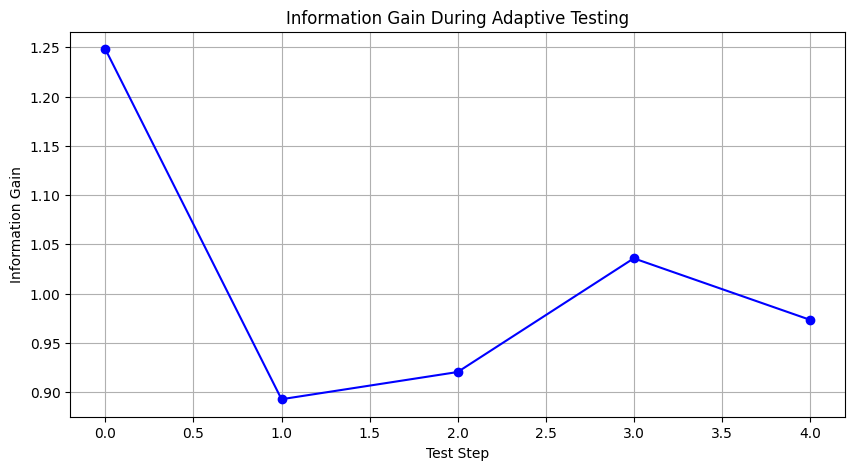

In [27]:
# Plot 1: Information Gain During Adaptive Testing
plt.figure(figsize=(10, 5))
plt.plot(information_gain, marker='o', linestyle='-', color='b')
plt.title("Information Gain During Adaptive Testing")
plt.xlabel("Test Step")
plt.ylabel("Information Gain")
plt.grid(True)
plt.show()



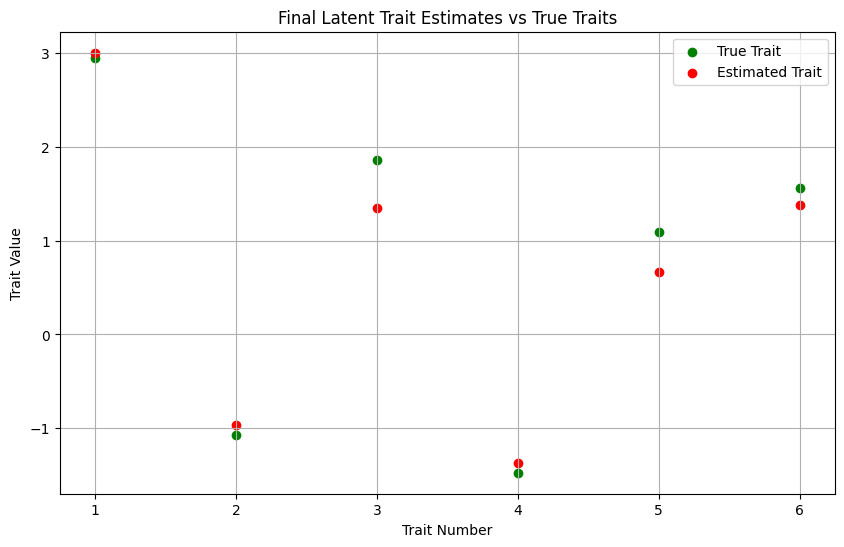

In [23]:
# Plot 2: Final Latent Trait Estimates vs True Traits
plt.figure(figsize=(10, 6))
for i in range(n_traits):
    plt.scatter([i+1], [true_th[i]], color='green', label='True Trait' if i == 0 else "")
    plt.scatter([i+1], [final_theta[i]], color='red', label='Estimated Trait' if i == 0 else "")
plt.title("Final Latent Trait Estimates vs True Traits")
plt.xlabel("Trait Number")
plt.ylabel("Trait Value")
plt.xticks(range(1, n_traits + 1))
plt.legend()
plt.grid(True)
plt.show()



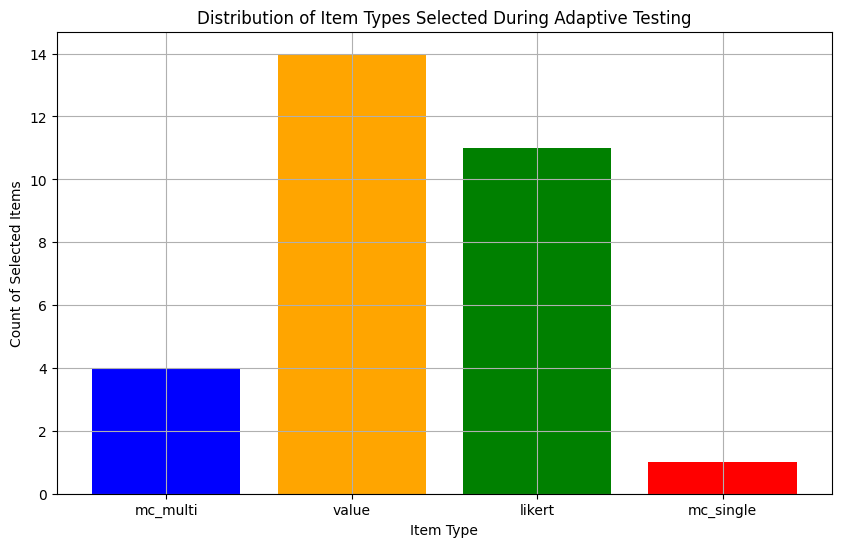

In [24]:
# Plot 3: Distribution of Selected Item Types
from collections import Counter
selected_item_types = [item_types[q] for q in selected_items]
type_counts = Counter(selected_item_types)

plt.figure(figsize=(10, 6))
plt.bar(type_counts.keys(), type_counts.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title("Distribution of Item Types Selected During Adaptive Testing")
plt.xlabel("Item Type")
plt.ylabel("Count of Selected Items")
plt.grid(True)
plt.show()

In [64]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class AdaptiveMIRT:
    def __init__(self, n_items=1000, n_traits=6, n_steps=5, probs=None):
        if probs is None:
            probs = [0.4, 0.2, 0.2, 0.1, 0.1]
        item_opts = ['likert', 'binary', 'value', 'mc_single', 'mc_multi']
        self.item_types = np.random.choice(item_opts, size=n_items, p=probs)
        self.n_items = n_items
        self.n_traits = n_traits
        self.n_steps = n_steps
        self.true_th = np.random.uniform(-3, 3, size=n_traits)
        self.est_th = np.zeros(n_traits)
        self.th_hist = []
        self.a_params = np.random.randn(n_items, n_traits)
        self.thresholds = [np.sort(np.random.uniform(-2, 2, size=4)) for _ in range(n_items)]
        self.bin_b = np.random.randn(n_items)
        self.val_thresh = np.sort(np.random.uniform(-2, 2, size=5))
        self.mc_params = np.random.randn(n_items, n_traits, 4)
        self.sel_items = []
        self.responses = []
        self.info_gain = []
        self.bounds = [(-3, 3)] * n_traits
        self.last_item = None

    def log_lik(self, th, item=None):
        if item is not None:
            return self._item_log_lik(th, item)
        else:
            ll = 0
            for i, q in enumerate(self.sel_items):
                ll += self._item_log_lik(th, q, self.responses[i])
            return -ll

    def _item_log_lik(self, th, item, resp=None):
        it_type = self.item_types[item]
        if it_type == "binary":
            prob = self.bin_prob(self.a_params[item], self.bin_b[item], th)
            if resp is None:
                return prob * (1 - prob)
            else:
                prob = np.clip(prob, 1e-8, 1 - 1e-8)
                return resp * np.log(prob) + (1 - resp) * np.log(1 - prob)
        elif it_type == "likert":
            probs = self.gpcm_prob(self.a_params[item], th, self.thresholds[item])
            return np.sum(probs * (1 - probs)) if resp is None else np.log(probs[resp - 1])
        elif it_type == "value":
            probs = self.gpcm_prob(self.a_params[item], th, self.val_thresh)
            return np.sum(probs * (1 - probs)) if resp is None else np.log(probs[resp])
        elif it_type == "mc_single":
            probs = self.mc_single_prob(self.mc_params[item], th)
            return np.sum(probs * (1 - probs)) if resp is None else np.log(probs[resp])
        elif it_type == "mc_multi":
            probs = self.mc_multi_prob(self.mc_params[item], th)
            return np.sum(probs * (1 - probs)) if resp is None else sum([resp[j] * np.log(probs[j]) + (1 - resp[j]) * np.log(1 - probs[j]) for j in range(len(resp))])

    def next_item(self):
        infos = []
        for i in range(self.n_items):
            if i in self.sel_items:
                infos.append(-np.inf)
                continue
            info = self.log_lik(self.est_th, item=i)
            infos.append(info + np.random.randn() * 0.1)
        next_item = np.argmax(infos)
        self.sel_items.append(next_item)
        self.last_item = next_item
        print(f"Selected Item {next_item+1}")
        return next_item

    def sim_resp(self):
        if self.last_item is None:
            raise ValueError("No item selected.")
        q = self.last_item
        it_type = self.item_types[q]
        if it_type == "binary":
            prob = self.bin_prob(self.a_params[q], self.bin_b[q], self.true_th)
            resp = np.random.binomial(1, prob)
        elif it_type == "likert":
            probs = self.gpcm_prob(self.a_params[q], self.true_th, self.thresholds[q])
            resp = np.argmax(np.random.multinomial(1, probs)) + 1
        elif it_type == "value":
            probs = self.gpcm_prob(self.a_params[q], self.true_th, self.val_thresh)
            resp = np.argmax(np.random.multinomial(1, probs))
        elif it_type == "mc_single":
            probs = self.mc_single_prob(self.mc_params[q], self.true_th)
            resp = np.argmax(np.random.multinomial(1, probs))
        elif it_type == "mc_multi":
            probs = self.mc_multi_prob(self.mc_params[q], self.true_th)
            resp = np.random.binomial(1, probs)
        self.responses.append(resp)
        self.info_gain.append(self.log_lik(self.est_th, item=q))
        print(f"Simulated Response: {resp}, Info Gain: {self.info_gain[-1]}")
        return resp

    def bin_prob(self, a, b, th):
        return expit(np.dot(a, th) - b)

    def gpcm_prob(self, a, th, thresholds):
        diff = np.dot(a, th)
        probs = [1] + [np.exp(diff - thresholds[k]) for k in range(len(thresholds))]
        return np.array(probs) / np.sum(probs)

    def mc_single_prob(self, a, th):
        expnt = np.dot(a.T, th)
        return np.exp(expnt) / np.sum(np.exp(expnt))

    def mc_multi_prob(self, a, th):
        probs = expit(np.dot(a.T, th))
        return np.clip(probs, 0, 1)

    def plot_results(self):
        fig, axs = plt.subplots(4, 1, figsize=(10, 20))
        axs[0].plot(self.info_gain, marker='o', linestyle='-', color='b')
        axs[0].set_title("Info Gain During Adaptive Testing")
        axs[0].set_xlabel("Step")
        axs[0].set_ylabel("Info Gain")
        axs[0].grid(True)
        for i in range(self.n_traits):
            axs[1].scatter([i+1], [self.true_th[i]], color='green', label='True' if i == 0 else "")
            axs[1].scatter([i+1], [self.est_th[i]], color='red', label='Est' if i == 0 else "")
        axs[1].set_title("Final Est. vs True Traits")
        axs[1].set_xlabel("Trait")
        axs[1].set_ylabel("Value")
        axs[1].legend()
        axs[1].grid(True)
        from collections import Counter
        sel_it_types = [self.item_types[q] for q in self.sel_items]
        it_counts = Counter(sel_it_types)
        axs[2].bar(it_counts.keys(), it_counts.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
        axs[2].set_title("Item Types Selected")
        axs[2].set_xlabel("Type")
        axs[2].set_ylabel("Count")
        axs[2].grid(True)
        th_hist = np.array(self.th_hist)
        for i in range(self.n_traits):
            axs[3].plot(th_hist[:, i], label=f"Est. Trait {i+1}")
            axs[3].axhline(self.true_th[i], color='green', linestyle='--', label=f"True Trait {i+1}" if i == 0 else "")
        axs[3].set_title("Theta Est. Change vs True Theta")
        axs[3].set_xlabel("Step")
        axs[3].set_ylabel("Theta Value")
        axs[3].legend()
        axs[3].grid(True)
        plt.tight_layout()
        plt.show()

    def update_theta(self):
        res = minimize(self.log_lik, self.est_th, method='L-BFGS-B', bounds=self.bounds)
        self.est_th = res.x[:self.n_traits]
        self.th_hist.append(self.est_th.copy())
        print(f"Updated Theta: {self.est_th}")


Selected Item 282
Simulated Response: [0 0 0 1], Info Gain: 1.0
Selected Item 340
Simulated Response: [0 0 0 0], Info Gain: 1.0
Selected Item 33
Simulated Response: [0 1 0 0], Info Gain: 1.0
Selected Item 573
Simulated Response: [0 1 1 0], Info Gain: 1.0
Selected Item 477
Simulated Response: [1 1 1 1], Info Gain: 1.0
Updated Theta: [-3.         -1.65078992 -0.39773109 -1.76286265  1.74967714 -1.84017776]
Selected Item 15
Simulated Response: 2, Info Gain: 0.7117509329554947
Selected Item 331
Simulated Response: 4, Info Gain: 0.7286720140353149
Selected Item 144
Simulated Response: 2, Info Gain: 0.7252443706129568
Selected Item 763
Simulated Response: 2, Info Gain: 0.7531716263873452
Selected Item 631
Simulated Response: 1, Info Gain: 0.7152489369499252
Updated Theta: [-3.         -1.78361855 -0.50392872 -2.08612981  1.91733901 -1.88906907]
Selected Item 264
Simulated Response: 2, Info Gain: 0.6921559763638053
Selected Item 968
Simulated Response: 1, Info Gain: 0.72315385249369
Selected 

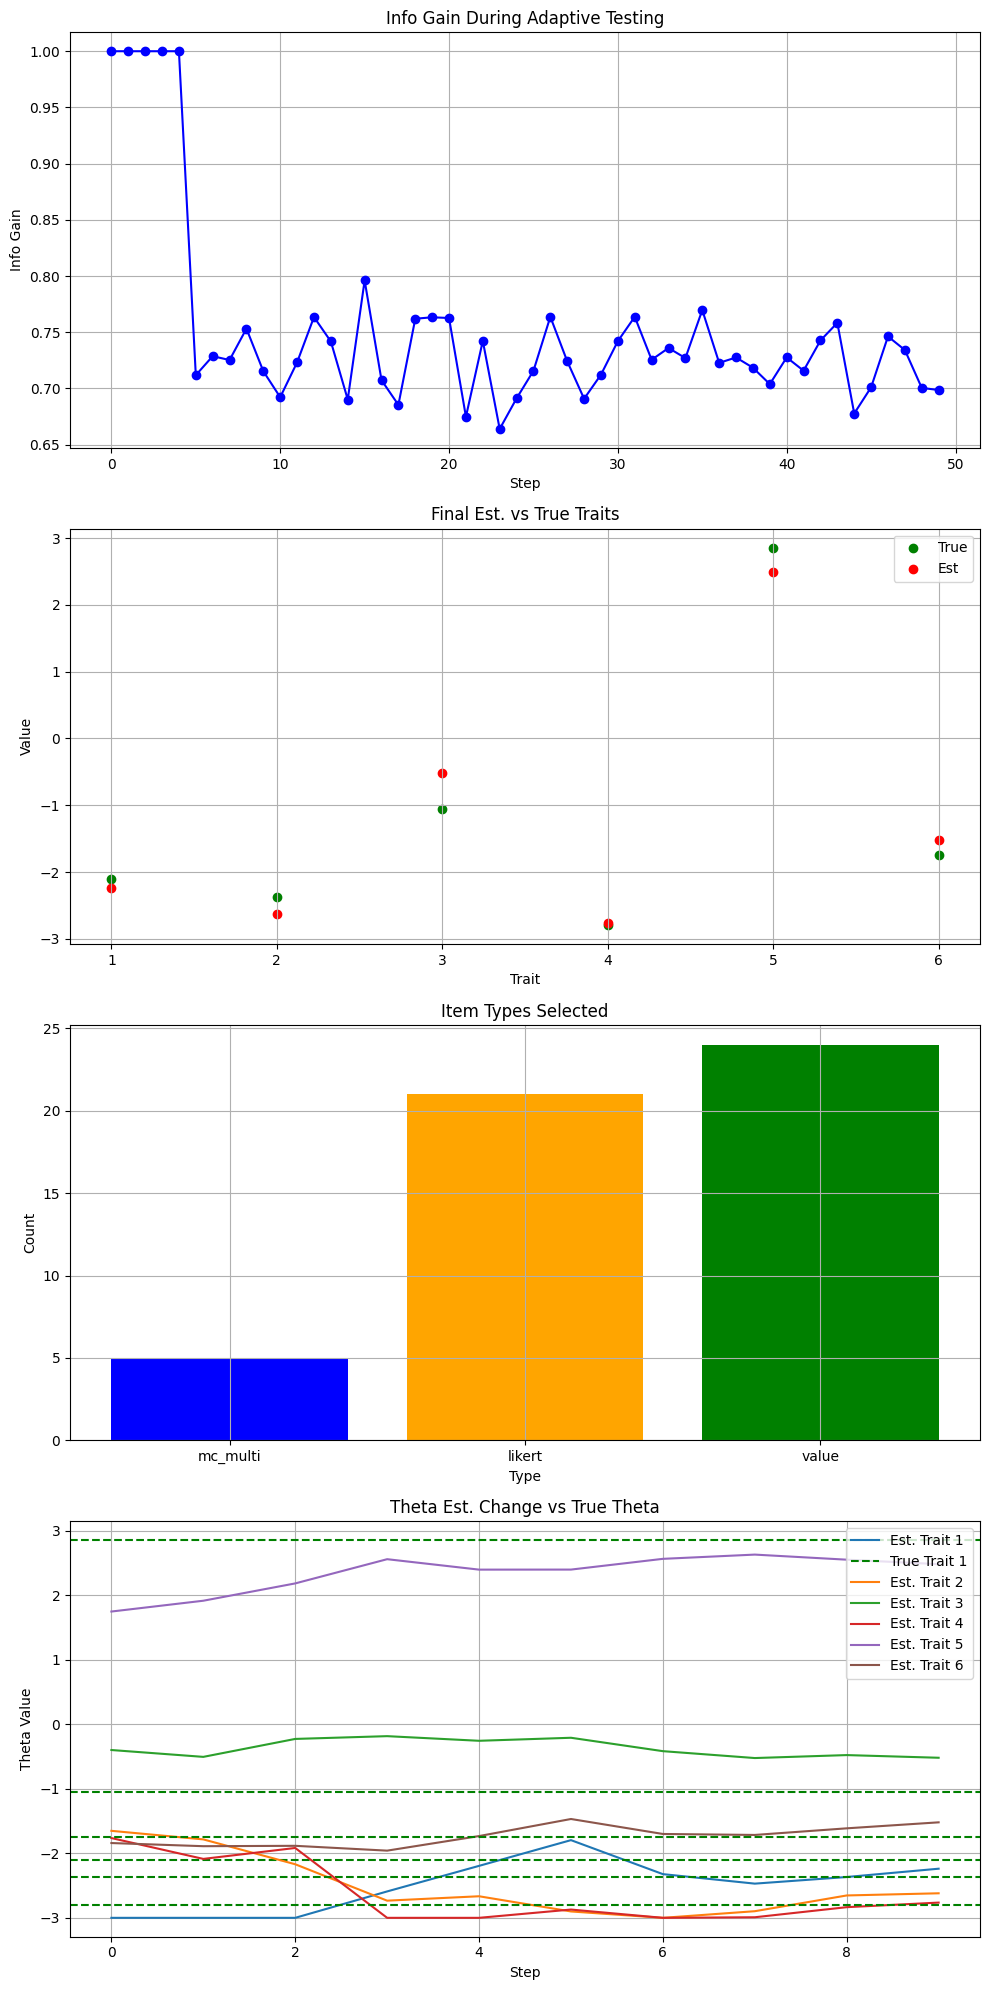

In [66]:
# Initialize the model
mirt_test = AdaptiveMIRT()

# Select items and simulate responses
for x in range(10):
    for _ in range(5):
        mirt_test.next_item()
        mirt_test.sim_resp()

    # Update the estimated theta values after responses
    mirt_test.update_theta()

# Plot the results
mirt_test.plot_results()